## Kaggle Titanic Project - Iteration 2 
Second submission for titanic kaggle competition. Given a data set of passengers with information like gender, age, class, and survival (0,1), we can create a model to predict whether a passenger would have survived on the titanic

links to continue working:
towards data science exmaple: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
kaggle: https://www.kaggle.com/c/titanic/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#statsmodels doesnt have an summary function for logit regressions, so we will import this fix
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [2]:
#read the training data file into "raw_data"
raw_data = pd.read_csv("train.csv")
raw_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Taussig, Mrs. Emil (Tillie Mandelbaum)",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
#the following cells are a couple of helpful methods to keep in mind of when doing some data exploration
#1
raw_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
#2
raw_data['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [5]:
#3
raw_data.groupby(raw_data['Survived']).mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


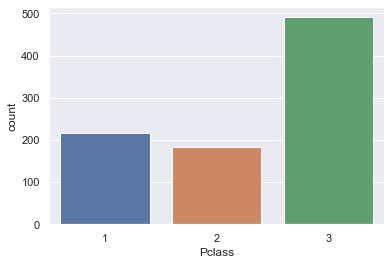

In [6]:
#4
sns.countplot(x = raw_data['Pclass'])
plt.show()

Text(0, 0.5, 'Frequency survival')

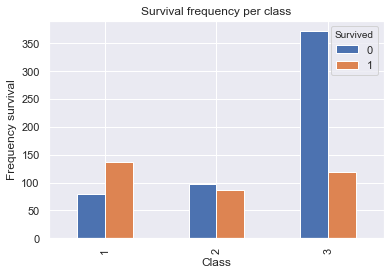

In [7]:
#5
#notice that we can either use raw_data["Pclass"] or raw_data.Pclass
#this graph informs us that mostly class 1 survived, and mostly class 3 did not. Pclass is indicator for future model
pd.crosstab(raw_data.Pclass,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency per class')
plt.xlabel('Class')
plt.ylabel('Frequency survival')


Text(0, 0.5, 'Frequency survival')

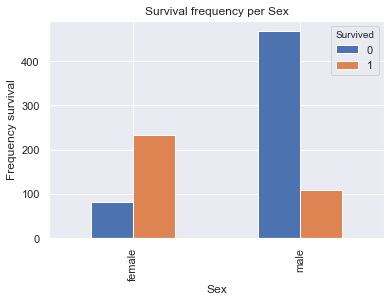

In [8]:
#6
#This informs us more likely to survive if female. Sex is good indicator for our future model
pd.crosstab(raw_data.Sex,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency per Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency survival')

Text(0, 0.5, 'Frequency survival')

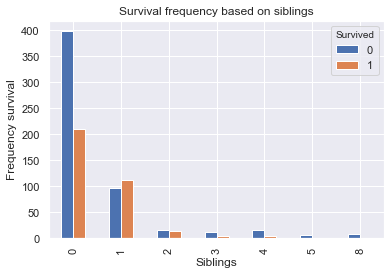

In [9]:
#7
#While a lot of people with 0 siblings survived, it also looks like 0 was the most common attribute. might not be helpful
pd.crosstab(raw_data.SibSp,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency based on siblings')
plt.xlabel('Siblings')
plt.ylabel('Frequency survival')

Text(0, 0.5, 'Frequency survival')

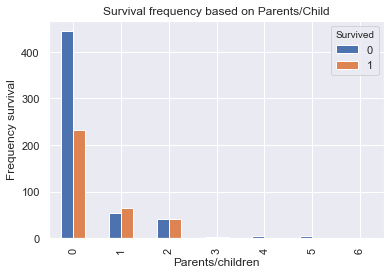

In [10]:
#8
#very similar result to above. might not be helpful
pd.crosstab(raw_data.Parch,raw_data.Survived).plot(kind='bar')
plt.title('Survival frequency based on Parents/Child')
plt.xlabel('Parents/children')
plt.ylabel('Frequency survival')

In [11]:
#Here we see 687 cabin entries are null out of possible 891, we should probably drop this column
#Missing 177 ages, we need to figure out a way to fill those missing ages
raw_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
#lets create a copy of our data frame and store in "data" and start making some changes
data = raw_data.copy()

#remove PassengerId, Cabin, Ticket, and Fare columns
data = data.drop(['Cabin', 'Ticket'], axis=1)

#remove the 2 entries with missing Embarked info
data.drop(data[pd.isnull(data['Embarked'])].index, inplace=True)

data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889,889,712.000000,889.000000,889.000000,889.000000,889
unique,NaN,NaN,NaN,889,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,"Taussig, Mrs. Emil (Tillie Mandelbaum)",male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,NaN,644
mean,446.000000,0.382452,2.311586,NaN,NaN,29.642093,0.524184,0.382452,32.096681,NaN
std,256.998173,0.486260,0.834700,NaN,NaN,14.492933,1.103705,0.806761,49.697504,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,224.000000,0.000000,2.000000,NaN,NaN,20.000000,0.000000,0.000000,7.895800,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,668.000000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,31.000000,NaN


In [15]:
#remove Fare outliers
q = data['Fare'].quantile(.90)
data = data[data['Fare']<q]
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
count,789.000000,789.000000,789.000000,789,789,620.000000,789.000000,789.000000,789.000000,789
unique,NaN,NaN,NaN,789,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,"Healy, Miss. Hanora ""Nora""",male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,1,537,NaN,NaN,NaN,NaN,595
mean,445.705957,0.339670,2.471483,NaN,NaN,29.011694,0.505703,0.356147,18.737711,NaN
std,260.539210,0.473898,0.742653,NaN,NaN,14.394345,1.140634,0.797301,15.086023,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,212.000000,0.000000,2.000000,NaN,NaN,20.000000,0.000000,0.000000,7.895800,NaN
50%,449.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,13.000000,NaN
75%,671.000000,1.000000,3.000000,NaN,NaN,37.000000,1.000000,0.000000,26.000000,NaN


In [16]:
#check what the data types are for each feature, and then change Sex and Embarked to categorical
#we will want to create dummies for these later, which is why we are changing to categorical
print(data.dtypes)

data['Sex'] = pd.Categorical(data['Sex'])
data['Embarked'] = pd.Categorical(data['Embarked'])

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object


In [17]:
#lets create a new feature called FamSize, and then remove SibSp and Parch
data['FamSize'] = data['SibSp'] + data['Parch']
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamSize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,0


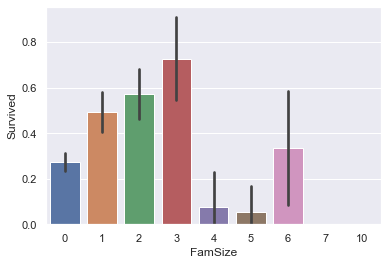

In [18]:
#analyzing the bar graph below, we see that passengers with famsize 0-3 have a much high probability of suriving
sns.barplot(data['FamSize'], data['Survived']);

In [19]:
#Lets take a look at how the names are structured
data['Name'].unique()[:10]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)'], dtype=object)

In [20]:
#Looks like names are last name + title + first name, lets parse out the titles and store in a new feature
data['Title']=0
for i in data:
    data['Title']=data['Name'].str.extract('([A-Za-z]+)\.', expand=False)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamSize,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S,0,Mr


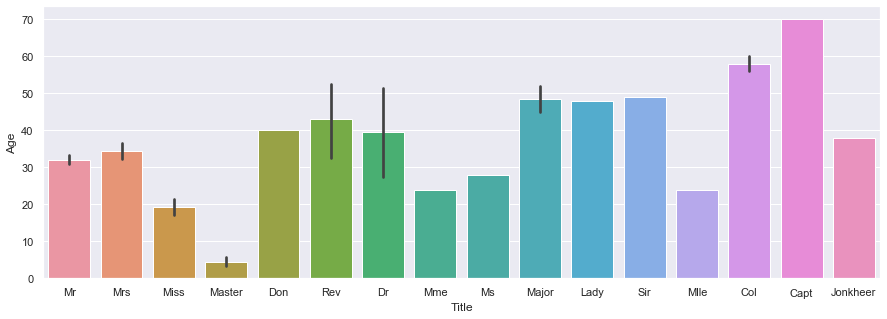

In [21]:
#plot the title vs age
plt.figure(figsize=(15,5))
sns.barplot(data['Title'], data['Age']);

In [22]:
#list the mean ages per title and store in a dictionary
age_means = data.groupby('Title')['Age'].mean()
map_means = age_means.to_dict()
map_means

{'Capt': 70.0,
 'Col': 58.0,
 'Don': 40.0,
 'Dr': 39.5,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.507575757575759,
 'Miss': 19.169642857142858,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.11095890410959,
 'Mrs': 34.4367816091954,
 'Ms': 28.0,
 'Rev': 43.166666666666664,
 'Sir': 49.0}

In [23]:
#locate the indexes that have missing ages, then insert the mean age based on the title of that index
age_index = data.loc[np.isnan(data['Age'])].index
data.loc[age_index,'Age'] = data['Title'].loc[age_index].map(map_means)

#remove the name column as we dont need this anymore
data = data.drop(['Name'], axis = 1)

data.describe(include='all')

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,FamSize,Title
count,789.000000,789.000000,789.000000,789,789.000000,789.000000,789,789.000000,789
unique,NaN,NaN,NaN,2,NaN,NaN,3,NaN,16
top,NaN,NaN,NaN,male,NaN,NaN,S,NaN,Mr
freq,NaN,NaN,NaN,537,NaN,NaN,595,NaN,482
mean,445.705957,0.339670,2.471483,NaN,29.006263,18.737711,NaN,0.861850,NaN
std,260.539210,0.473898,0.742653,NaN,13.119625,15.086023,NaN,1.651004,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,NaN,0.000000,NaN
25%,212.000000,0.000000,2.000000,NaN,20.000000,7.895800,NaN,0.000000,NaN
50%,449.000000,0.000000,3.000000,NaN,30.000000,13.000000,NaN,0.000000,NaN
75%,671.000000,1.000000,3.000000,NaN,34.436782,26.000000,NaN,1.000000,NaN


In [24]:
#map titles in groups and then update titles in the data frame
titles_dict = {'Capt': 'Other',
               'Major': 'Other',
               'Jonkheer': 'Other',
               'Don': 'Other',
               'Sir': 'Other',
               'Dr': 'Other',
               'Rev': 'Other',
               'Countess': 'Other',
               'Dona': 'Other',
               'Mme': 'Mrs',
               'Mlle': 'Miss',
               'Ms': 'Miss',
               'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Master',
               'Lady': 'Other'}

data['Title'] = data['Title'].map(titles_dict)
data['Title'] = pd.Categorical(data['Title'])

In [25]:
#lets group the ages into three categories of child, adult, elder
data['Age'] = pd.cut(data['Age'], bins=[0, 12, 50, 200], labels=['Child','Adult','Elder'])

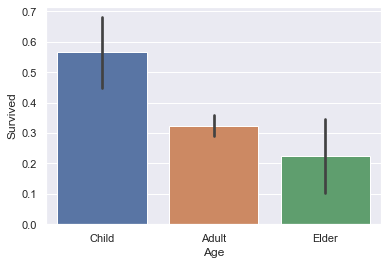

In [26]:
sns.barplot(data['Age'],data['Survived'])

In [27]:
data = data.drop(['PassengerId'],axis = 1)
data['Pclass'] = pd.Categorical(data['Pclass'])

In [28]:
#we have categorical data in Embarked that needs to be represented in our regression.
#to do this, we introduce dummies that will take the place of the categorical data
#if we have N categories, we need N-1 dummies, otherwise multicollinearity will be introduced
#to do this we use the get_dummies method and set drop_first=True so that we get N-1 dummies

data_with_dummies = pd.get_dummies(data, drop_first=True)
data_with_dummies.head()

,Survived,Fare,FamSize,Pclass_2,Pclass_3,Sex_male,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,7.2500,1,0,1,1,1,0,0,1,0,1,0,0
1,1,71.2833,1,0,0,0,1,0,0,0,0,0,1,0
2,1,7.9250,0,0,1,0,1,0,0,1,1,0,0,0
3,1,53.1000,1,0,0,0,1,0,0,1,0,0,1,0
4,0,8.0500,0,0,1,1,1,0,0,1,0,1,0,0


In [29]:
#Create new data frames of our target and inputs
targets = data_with_dummies['Survived']
inputs = data_with_dummies.drop(['Survived'], axis=1)
inputs

,Fare,FamSize,Pclass_2,Pclass_3,Sex_male,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,7.2500,1,0,1,1,1,0,0,1,0,1,0,0
1,71.2833,1,0,0,0,1,0,0,0,0,0,1,0
2,7.9250,0,0,1,0,1,0,0,1,1,0,0,0
3,53.1000,1,0,0,0,1,0,0,1,0,0,1,0
4,8.0500,0,0,1,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13.0000,0,1,0,1,1,0,0,1,0,0,0,1
887,30.0000,0,0,0,0,1,0,0,1,1,0,0,0
888,23.4500,3,0,1,0,1,0,0,1,1,0,0,0
889,30.0000,0,0,0,1,1,0,0,0,0,1,0,0


In [30]:
#cols = ['Pclass', 'Sex', 'Age','SibSp']
#x = data_cleaned[cols]
#y = data_cleaned['Survived']

#log_reg=sm.Logit(targets,inputs_scaled)
#results=log_reg.fit()
#print(results.summary2())

log_reg = LogisticRegression()
log_reg.fit(inputs,targets)


C:\Users\yoni.nackash\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
#lets run our model with our inputs to receive training outputs, and then compare those with the actual targets
train_pred = log_reg.predict(inputs)

cnf_matrix = metrics.confusion_matrix(targets, train_pred)
cnf_matrix

array([[463,  58],
       [ 83, 185]], dtype=int64)

In [ ]:
raw_test_data = pd.read_csv("test.csv")
test_data = raw_test_data.copy()

#make changes to test data then write to CSV

In [ ]:
final_results1.to_csv('output.csv', index=False)